In [183]:
import os
import sys
import time
import pickle as pk
from typing import Union, Tuple
from collections import OrderedDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import Parameter
from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader

#from torchsummary import summary
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from statistics import mean
import matplotlib.pyplot as plt

In [116]:
import numpy as np

with np.load('rnn-challenge-data.npz') as f:
    train_x = f['data_x']
    train_y = f['data_y']
    val_x = f['val_x']
    val_y = f['val_y']
    test_x = f['test_x']
    
print('train_x shape: {}'.format(train_x.shape))
print('train_y shape: {}'.format(train_y.shape))
print('val_x shape: {}'.format(val_x.shape))
print('val_y shape: {}'.format(val_y.shape))
print('test_x shape: {}'.format(test_x.shape))

train_x shape: (400,)
train_y shape: (400,)
val_x shape: (100,)
val_y shape: (100,)
test_x shape: (250,)


In [117]:
import pandas as pd

In [118]:
df=pd.DataFrame(train_x)
df.head()

,0
0,CTAGCTGAGCTACTGAGCTACAGTTGACTGACCAGTCAGTGCTAGC...
1,TGACGCTAGCTAGCTAAGTCACGTTGACAGTCACGTACGTAGTCAC...
2,AGTCACGTAGTCAGTCGCTAGCTAACGTACGTCAGTGCTACAGTCA...
3,GTCAGTCACTGACAGTGTCACAGTCTGACTGACTGAGTCAGATCAG...
4,CAGTGATCCAGTCTAGGATCGATCCTAGCTAGGTCACTAGGATCCT...


In [119]:
train_y

array([2, 0, 0, 4, 3, 3, 3, 0, 4, 2, 3, 2, 4, 3, 2, 3, 4, 0, 2, 0, 2, 0,
       3, 1, 4, 0, 2, 2, 0, 0, 2, 1, 4, 0, 3, 0, 1, 1, 3, 4, 3, 3, 2, 3,
       4, 1, 0, 2, 0, 2, 4, 2, 4, 4, 1, 0, 2, 3, 2, 2, 1, 0, 4, 4, 4, 0,
       0, 2, 3, 3, 2, 2, 3, 0, 3, 2, 3, 1, 3, 4, 1, 4, 1, 4, 0, 2, 1, 4,
       0, 1, 1, 1, 1, 4, 2, 4, 4, 3, 0, 0, 0, 0, 3, 2, 3, 2, 1, 0, 1, 3,
       2, 2, 1, 2, 4, 1, 2, 1, 4, 3, 4, 1, 4, 0, 4, 0, 3, 0, 1, 2, 3, 1,
       0, 0, 1, 0, 2, 4, 4, 2, 1, 2, 0, 0, 2, 3, 4, 4, 4, 4, 3, 2, 0, 0,
       0, 4, 4, 4, 2, 1, 1, 0, 2, 1, 4, 4, 1, 0, 4, 0, 4, 4, 1, 3, 3, 0,
       0, 1, 0, 2, 0, 0, 3, 0, 3, 3, 0, 4, 2, 2, 4, 4, 0, 2, 4, 1, 3, 2,
       0, 4, 1, 2, 4, 3, 2, 2, 4, 0, 1, 2, 4, 1, 4, 1, 1, 2, 2, 2, 1, 1,
       0, 2, 3, 1, 4, 0, 4, 2, 0, 2, 0, 1, 2, 3, 2, 3, 0, 3, 1, 3, 0, 2,
       4, 3, 0, 1, 4, 4, 1, 2, 3, 0, 4, 3, 0, 4, 1, 2, 4, 4, 2, 2, 4, 3,
       3, 1, 3, 1, 0, 1, 3, 3, 4, 2, 1, 3, 4, 0, 2, 0, 3, 0, 3, 0, 0, 2,
       1, 3, 2, 2, 4, 1, 4, 0, 1, 1, 0, 2, 3, 1, 3,

In [120]:
vocab=['A', 'C', 'G', 'T']
def char_to_int(data,vocab):
    # Creating a mapping from unique characters to indices
    char2idx = {u:i for i, u in enumerate(vocab)}
    text_as_int=[]
    for text in data:
        text_as_int.append(np.array([char2idx[c] for c in text]))
    return np.array(text_as_int)

# Create a mapping from indices to characters
idx2char = np.array(vocab)

In [121]:
def one_hot_encode(arr, n_labels=4,max_sequence_len=2000):
    encoded=[]
    eye = np.eye(n_labels)
    for code in arr:
        encoded.append(np.vstack([
                np.array([eye[c] for c in code]),
                np.zeros((max_sequence_len - len(code), n_labels))
            ]
            ))

    return np.array(encoded).swapaxes(1,2)

In [122]:
text_as_int=char_to_int(train_x,vocab)

In [123]:
text_as_int.shape

(400, 400)

In [124]:
try:
    text_as_int=char_to_int(train_x,vocab)
    X_train = one_hot_encode(text_as_int)
    y_train = np.eye(5)[train_y]
    
    text_as_int=char_to_int(val_x,vocab)
    X_val = one_hot_encode(text_as_int)
    y_val = np.eye(5)[val_y]
    
    text_as_int=char_to_int(test_x,vocab)
    X_test = one_hot_encode(text_as_int)

    del train_x, val_x, test_x
except Exception as e:
    print(e)
    pass
    # step already done

In [125]:
X_train.shape

(400, 4, 2000)

dtype('float64')

In [166]:
# summarize the data
inputs = torch.tensor(X_train).float()
targets = torch.tensor(train_y).float()
targets = targets.type(torch.LongTensor)
# Define dataset
train_ds = TensorDataset(inputs, targets)

batch_size = 16
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

y_test=val_y

inputs = torch.tensor(X_val).float()
targets = torch.tensor(y_test).float()
targets = targets.type(torch.LongTensor)
# Define dataset
test_ds = TensorDataset(inputs, targets)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [188]:
def plot_loss(epochs,train_losses,test_losses,model_name):
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.rcParams['figure.dpi'] = 100
  plt.plot(range(epochs),train_losses, label='train loss')
  plt.plot(range(epochs),test_losses,label='test loss')
  plt.title(model_name)
  plt.legend()
  plt.show()
def plot_acc(epochs,train_losses,test_losses,model_name):
  plt.rcParams['figure.figsize'] = [10, 5]
  plt.rcParams['figure.dpi'] = 100
  plt.plot(range(epochs),train_losses, label='train acc')
  plt.plot(range(epochs),test_losses,label='test acc')
  plt.title(model_name)
  plt.legend()
  plt.show()

In [184]:
def train(
    model: nn.Module, 
    optimizer: optim.Optimizer, 
    data: Union[DataLoader, Tuple[DataLoader]], 
    max_epochs: int, 
    cuda=False):
  
  use_test = False
  if isinstance(data, DataLoader):
    train_loader = data
  elif isinstance(data, tuple):
    if len(data) == 2:
      train_loader, test_loader = data
      if not isinstance(train_loader, DataLoader):
        raise TypeError(f'Expected 1st entry of type DataLoader, but got {type(train_loader)}!')
      if not isinstance(test_loader, DataLoader):
        raise TypeError(f'Expected 2nd entry of type DataLoader, but got {type(test_loader)}!')
      use_test = True
    else:
      raise ValueError(f'Expected tuple of length 2, but got {len(data)}!')
  
  
  criterion = nn.CrossEntropyLoss()
  model.train()
  train_losses = []
  test_losses=[]
  train_acc=[]
  test_acc=[]
  batch_total = len(train_loader)
  for epoch in range(max_epochs):
    samples_total = 0
    samples_correct = 0
    losses=[]
    t_losses=[]
    for batch_idx, batch in enumerate(train_loader):
      x, y = batch
      if cuda:
        x, y = x.cuda(), y.cuda()
      # Clear gradients w.r.t. parameters
      optimizer.zero_grad()
      output = model(x)
      loss = criterion(output, y)
      loss.backward()
      optimizer.step()
      
      yhat = torch.argmax(output, dim=1)

      samples_total += len(y)
      samples_correct += torch.sum(yhat == y)
      losses.append(loss.item())



    acc = float(samples_correct) / float(samples_total)
    train_acc.append(acc)
    train_losses.append(mean(losses))
    if use_test:
      model.eval()
      samples_total = 0
      samples_correct = 0
      for test_x, test_y in test_loader:
        if cuda:
          test_x, test_y = test_x.cuda(), test_y.cuda()
        test_output = model(test_x)
        test_yhat = torch.argmax(test_output, dim=1)
        loss = criterion(test_output, test_y)
        samples_total += len(test_y)
        samples_correct += torch.sum(test_yhat == test_y)
        t_losses.append(loss.item())
      t_acc = float(samples_correct) / float(samples_total)
      test_acc.append(t_acc)
      test_losses.append(mean(t_losses))
      model.train()

      sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Loss: {mean(losses):.2f} Acc: {acc:.2%} Test loss: {mean(test_losses):.2f} Test acc: {t_acc:.2%}')
    else:
      sys.stdout.write(f'\rEpoch: {epoch}/{max_epochs} Loss: {mean(losses):.6f} Acc: {acc:.2%}')

  return train_losses, test_losses,train_acc,test_acc

In [170]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim*4, 75)
        self.fc2 = nn.Linear(75, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(batch_size,-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [193]:

model = Model(input_size=2000, output_size=5, hidden_dim=40, n_layers=3)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses, test_losses,train_acc,test_acc = train(model, optimizer, (train_loader, test_loader), max_epochs=100)

Epoch: 99/100 Loss: 0.00 Acc: 100.00% Test loss: 0.12 Test acc: 96.00%

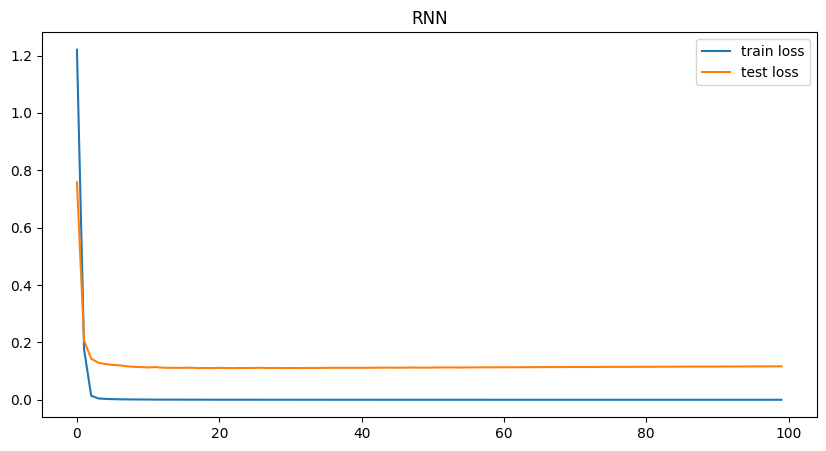

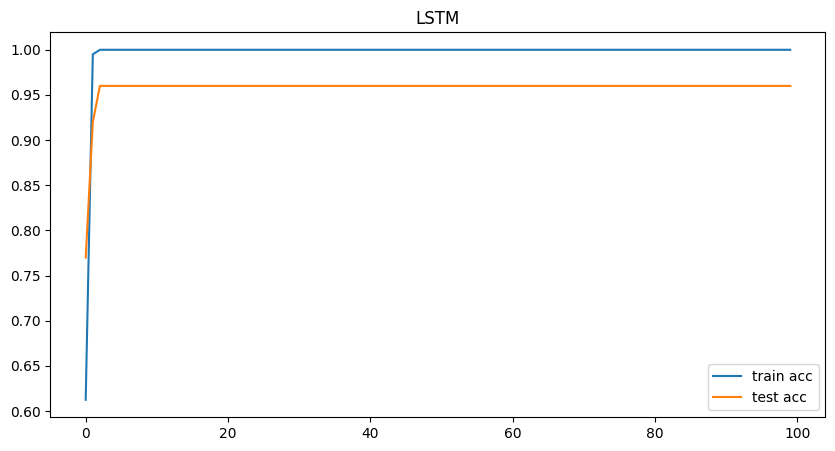

In [195]:
plot_loss(100,train_losses,test_losses,'RNN')
plot_acc(100,train_acc,test_acc,'RNN')

In [196]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(LSTM_Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, bidirectional=True)   
        # Fully connected layer
        self.fc1 = nn.Linear(hidden_dim*4*2, 75)
        self.fc2 = nn.Linear(75, output_size)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.n_layers*2, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.n_layers*2, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(batch_size,-1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [197]:
model = LSTM_Model(input_size=2000, output_size=5, hidden_dim=40, n_layers=1)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_losses, test_losses,train_acc,test_acc = train(model, optimizer, (train_loader, test_loader), max_epochs=100)

Epoch: 99/100 Loss: 0.00 Acc: 100.00% Test loss: 0.03 Test acc: 100.00%

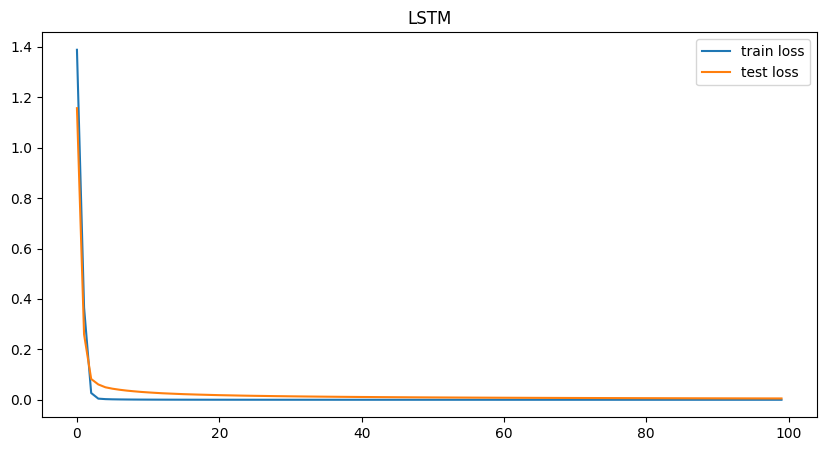

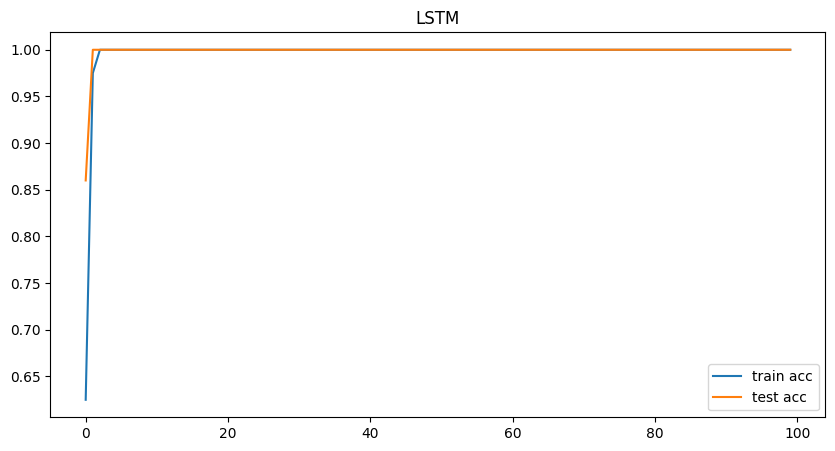

In [199]:
plot_loss(100,train_losses,test_losses,'LSTM')
plot_acc(100,train_acc,test_acc,'LSTM')